# Employee Promotion Prediction
Addison 2024-03-15

## I. Introduction

The objective of this project is to build a model to identify which employees will be recommended for promotion based on a dataset containing 54,808 rows, each representing the demographics, backgrounds, and work performance of an employee. The dataset could be obtained through this link:

https://www.kaggle.com/datasets/muhammadimran112233/employees-evaluation-for-promotion


Here are the descriptions for all the columns:

**employee_id** - Unique ID for the employee

**department** - Department of employee

**region** - Region of employment (unordered)

**education** - Educational level of the employee

**gender** - The employee's gender (**m:** Male, **f:** Female)

**recruitment_channel** - The channel from which the employee was recruited

**no_of_trainings** - The number of trainings that the employee completed last year
 
**age** - The employee's age

**previous_year_rating** - The employee's rating score from the previous year (**min:** 1, **max:** 5)

**length_of_service** - The number of years that the employee has worked for the company

**awards_won** - If the employee won any awards during the previous year, it is denoted as 1; otherwise, it is 0

**avg_training_score** - The employee's average score in current training evaluations (**min:** 0, **max:** 100)

**is_promoted** - If the employee is recommended for promotion, it is denoted as 1; otherwise, it is 0   

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, precision_score, f1_score

from sklearn.ensemble import RandomForestClassifier

## II. Data exploration

To begin, let's take a brief glance at the initial rows of the data and gather key details to visualize the data's appearance. This includes exploring the data types of columns, as well as noting the count of unique values and non-null entries in each column.

In [2]:
data = pd.read_csv('employee_promotion.csv')
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


In [4]:
data.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

In [5]:
data.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
awards_won                  2
avg_training_score         59
is_promoted                 2
dtype: int64

From the statistics above, it's noticeable that columns **'education', 'previous_year_rating', and 'avg_training_score'** have null values. Since the total number of null values is quite significant compared to the whole dataset, we'll fill in such null values later.

Now, we will visualize the categorical variables for exploratory purposes. Specifically, we'll examine the proportion of employees who are recommended to be promoted versus those who are not in each **department, educational level, gender group, recruitment channel, previous year's rating group, and award winning group.**

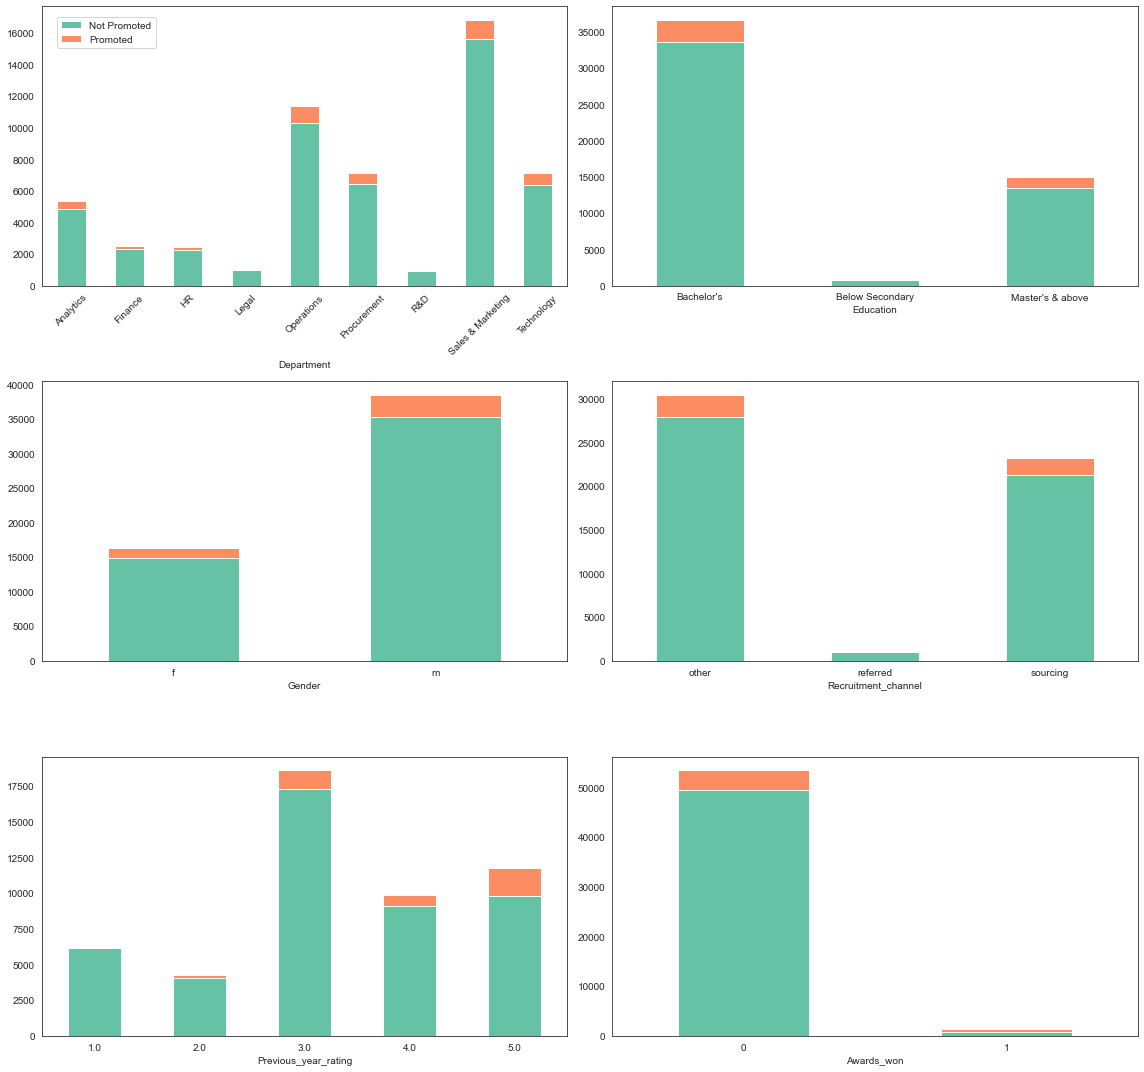

In [6]:
# Set the style to white
sns.set_style("white")

# Set the palette to Set2
sns.set_palette("Set2")

cat_columns = ['department', 'education', 'gender', 'recruitment_channel', 'previous_year_rating', 'awards_won']
fig, axes = plt.subplots(3, 2, figsize=(16, 15))

# Create a single legend for all subplots
handles, labels = None, None

for i, (col, ax) in enumerate(zip(cat_columns, axes.flatten())):
    counts = data.groupby([col, 'is_promoted']).size().unstack()
    counts.plot.bar(stacked=True, ax=ax)
    ax.set_xlabel(col.capitalize())
    
    # Rotate x-labels by 60 degrees if col is 'department'
    rotation_angle = 45 if col == 'department' else 0
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation_angle, ha='center')

    # Store handles and labels for creating a single legend
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=['Not Promoted', 'Promoted'], loc='upper left', bbox_to_anchor=(0.02, 0.98))  # Adjust the bbox_to_anchor as needed
    else:
        ax.get_legend().remove()

# Add a single legend
plt.tight_layout()
plt.show()

From the charts above, it's evident that the proportion of employees who are recommended to be promoted versus those who are not in each category is significantly imbalanced. Thus, we'll use the **weighted and micro** averaging methods to compute precision and F1 scores of our prediction model later.

The number of employees who are recommended to be promoted also has a **positive correlation** with the total number of employees in each category: the higher the number of employees in a certain category, the higher the number of employees who are recommended to be promoted in that category.

The **Sales & Marketing department** has the highest number of employees (roughly 17k) and those who are recommended to be promoted (roughly 1.2k), followed by the Operations department (roughly 11k employees and 1k employees recommended to be promoted).

The majority of employees hold a **Bachelor's degree** (approximately 28k), among whom there are about 3k employees who are recommended to be promoted, followed by those holding a Master's degree (roughly 15k employees and 1.5k employees recommended to be promoted).

**Male employees** also significantly outnumber their counterparts (roughly 38k vs roughly 16k). The number of male employees who are recommended to be promoted is roughly double that of their counterparts.

Most employees are recruited from **channels other than sourcing and referral** (approximately 30k vs 23k vs 1k). Roughly 2.5k employees who are recruited from other channels are recommended to be promoted, while roughly 2k employees who are recruited via sourcing are recommended to be promoted.

Employees with **higher previous year's rating scores** tend to be recommended for promotion. The majority of employees receive a previous year's rating score of 3.0 (roughly 18k). However, the majority of employees who are recommended for promotion are those receiving a previous year's rating score of 5.0 (roughly 2k), followed by those who receive a previous year's rating score of 3.0 (roughly 1.5k).

Although the majority of employees recommended for promotion did not win any awards the previous year (roughly 4k), **employees winning awards last year** have a more significant probability of being recommended for promotion (0.44 vs 0.07).

Now, we are going to examine the proportion of employees who are recommended to be promoted versus those who are not in each **region of employment.**

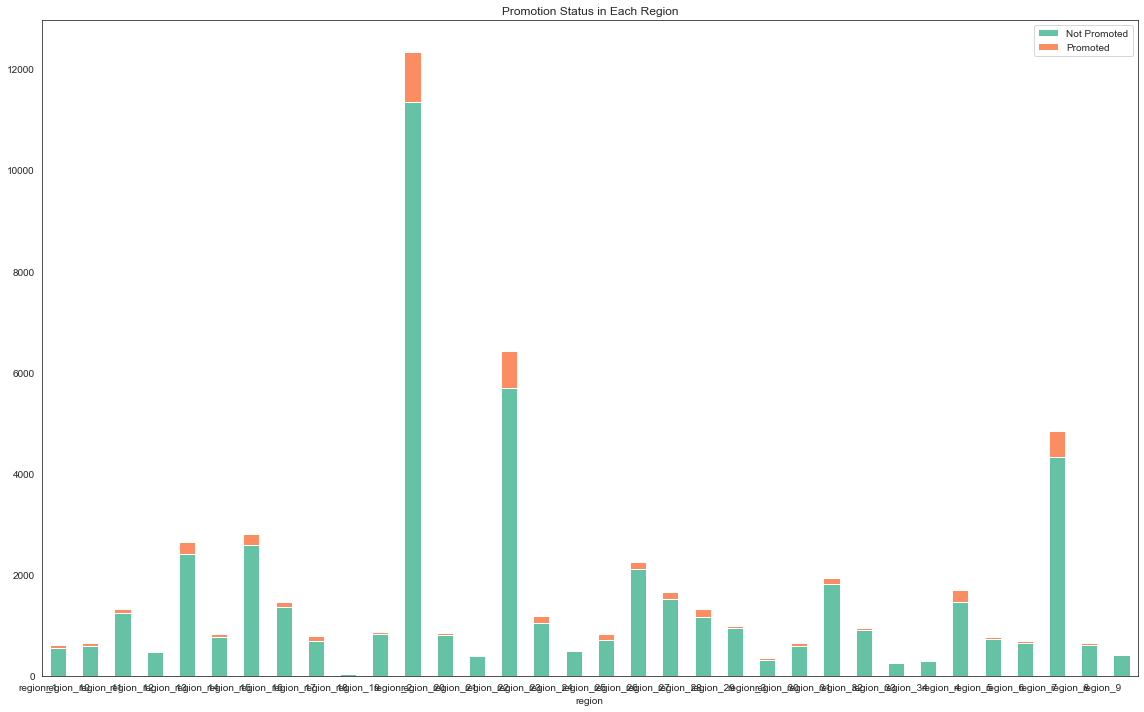

In [7]:
# Set the style to white
sns.set_style("white")

# Set the palette to Set2
sns.set_palette("Set2")

# Group data by region and promotion status, then count the occurrences
promotion_counts = data.groupby(['region', 'is_promoted']).size().unstack()

# Enlarge the plot by adjusting the figsize parameter in plt.subplots()
fig, ax = plt.subplots(figsize=(16, 10))

# Plot the promotion counts for each region
promotion_counts.plot(kind='bar', stacked=True, ax=ax)
plt.title('Promotion Status in Each Region')
plt.xticks(rotation=360, ha='right')
plt.legend(['Not Promoted', 'Promoted'], loc='upper right')
plt.tight_layout()
plt.show()


From the chart above, it's noticeable that the majority of employees, as well as those who are recommended to be promoted, are from **region 2** (roughly 12.5k), followed by region 22 and region 7.

Now, we're going to examine the distribution of employees who are recommended to be promoted and those who are not across different discrete variables: **'no_of_trainings', 'age', 'length_of_service', and 'avg_training_score'.**

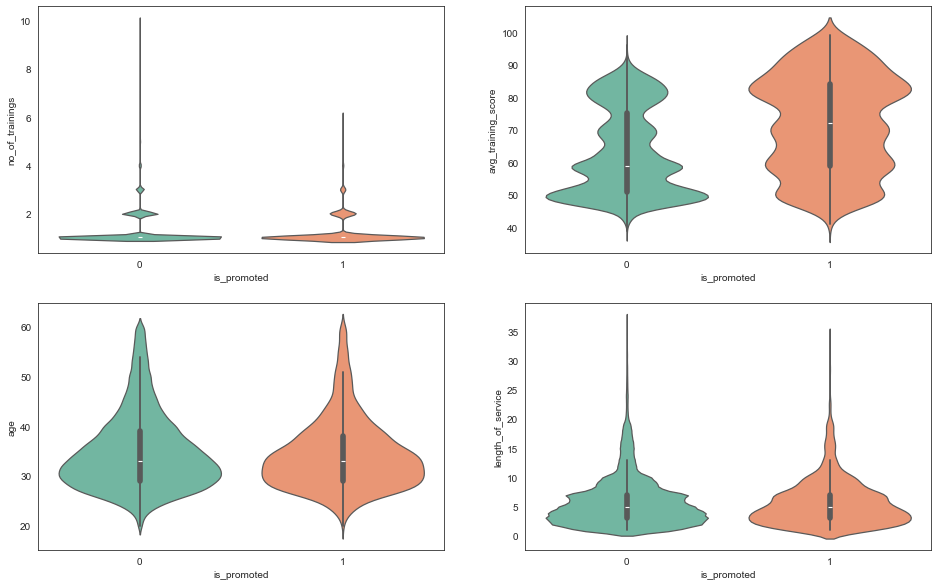

In [8]:
column = ['no_of_trainings', 'avg_training_score', 'age','length_of_service']
fig = plt.figure(figsize=(16,10))

for i, col in enumerate(column):
    ax = plt.subplot(2, 2, i+1)
    sns.violinplot(y=data[col], x=data["is_promoted"], ax=ax, hue = data["is_promoted"], palette='Set2', legend=False)

Based on the charts above, it's clear that the tendency of being recommended for promotion is likely dependent on the **average score in current training evaluations** rather than the **number of trainings** that the employee completed last year. The higher the average score in current training evaluations, the higher the chance of being recommended for promotion.

Regarding **'age' and 'length_of_service'**, the distribution of employees recommended for promotion and those who are not is quite similar. Thus, it could be implied that **'age' and 'length_of_service'** are not crucial factors determining the tendency of being recommended for promotion. The majority of employees recommended for promotion are around 30 years old and have worked for the company for roughly 2-3 years.

## III. Data imputation

Now, we're going to fill in null rows in columns  **'education', 'previous_year_rating', and 'avg_training_score'**

In [9]:
# Count the frequency of each unique value in the 'education' column
data['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

Since the **"education"** classes are categorical and imbalanced in the dataset, the model's performance may be biased towards the majority class. In such cases, using the **mode method** may result in better predictions for the missing values.

In [10]:
# Fill missing values in the 'education' column with the mode (most frequent value)
data['education'].fillna(value=data['education'].mode()[0], inplace=True)

Next, we're going to plot the distribution of **'previous_year_rating'**.

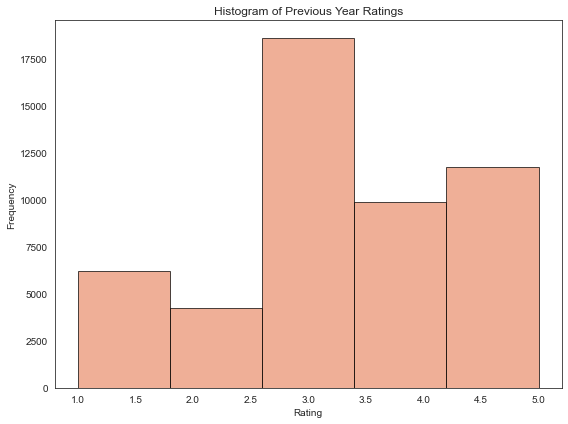

In [11]:
sns.set_palette("flare")

plt.figure(figsize=(8, 6))
data['previous_year_rating'].hist(bins=5, edgecolor='black', alpha=0.7)
plt.title('Histogram of Previous Year Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.grid(False) 

plt.show()

Based on the chart above, it's evident that **'previous_year_rating'** is normally distributed. Since it's also categorical, we'll use the **mode method** to fill in missing values.

In [12]:
# Fill missing values in the 'previous_year_rating' column with the mode value
data['previous_year_rating'].fillna(value=data['previous_year_rating'].mode()[0], inplace=True)

Next, we're going to plot the distribution of **'avg_training_score'**.

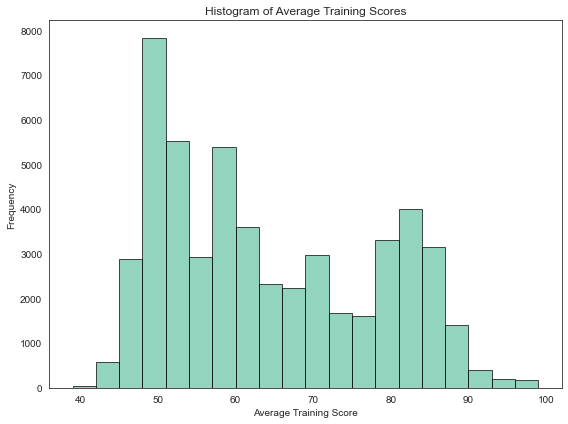

In [13]:
# Plot histogram of 'avg_training_score' column
sns.set_palette("Set2")

plt.figure(figsize=(8, 6))
data['avg_training_score'].hist(bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Average Training Scores')
plt.xlabel('Average Training Score')
plt.ylabel('Frequency')
plt.grid(False) 
plt.tight_layout()
plt.show()

Based on the chart above, it's evident that **'avg_training_score'** is right-skewed distributed. Since it's also discrete, we'll use the **median method** to fill in missing values.

In [14]:
# Fill missing values in the 'avg_training_score' column with the median value
data['avg_training_score'].fillna(value=data['avg_training_score'].median(), inplace=True)

In [15]:
# Check for missing values in the DataFrame
data.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won              0
avg_training_score      0
is_promoted             0
dtype: int64

The statistics above indicate that our dataset is now free of null values and ready for building a predictive model.

## IV. Data engineering

To avoid the SettingWithCopyWarning error, we'll slice our dataset as shown below without making any alterations to the dataset.

In [16]:
data = data.loc[:, 'employee_id': 'is_promoted']

Next, we'll convert **'department', 'region', 'education', 'gender', 'recruitment_channel', 'previous_year_rating'** columns to categorical codes

In [17]:
data["department"] = data["department"].astype("category").cat.codes
data["region"] = data["region"].astype("category").cat.codes
data["education"] = data["education"].astype("category").cat.codes
data["gender"] = data["gender"].astype("category").cat.codes
data["recruitment_channel"] = data["recruitment_channel"].astype("category").cat.codes
data["previous_year_rating"] = data["previous_year_rating"].astype("category").cat.codes

## V. Predictive model building and evaluation


Next, we'll drop **'is_promoted' and 'employee_id'** from the dataset and assign the new dataset to variable **X**. In this project, we'll use all variables except **'employee_id'** to predict whether employees will be recommended to be promoted.

Then, we'll assign the target variable **'is_promoted'** to variable **y**.

Afterwards, we'll split the dataset into training and testing sets and allocate 20% of the data for testing.

In [18]:
X = data.drop(["is_promoted",'employee_id' ], axis=1)
y = data["is_promoted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

In this project, we'll use **Random Forest classifier** for our predictive model and **weighted** and **mircro** averaging methods when calculating precision and f1 score.

**Micro averaging** helps highlight the overall effectiveness of the model, while **weighted averaging** provides insights into its performance on individual classes, especially those that are less underrepresented. 

In [19]:
# Initialize the Random Forest classifier with specified hyperparameters
rf = RandomForestClassifier(max_depth=10, min_samples_split=15, n_estimators=25, random_state=222)

# Train the Random Forest classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
preds = rf.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, preds)

# Calculate the precision of the predictions
precision = precision_score(y_test, preds, average='weighted')

# Calculate the F1 score of the predictions
f1 = f1_score(y_test, preds, average='weighted')

# Print the precision, accuracy, and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision - weighted: {precision:.4f}")
print(f"F1 score - weighted: {f1:.4f}")

Accuracy: 0.9280
Precision - weighted: 0.9262
F1 score - weighted: 0.9047


In [20]:
# Calculate the precision of the predictions
precision = precision_score(y_test, preds, average='micro')

# Calculate the F1 score of the predictions
f1 = f1_score(y_test, preds, average='micro')

# Print the precision, accuracy, and F1 score
print(f"Precision - micro: {precision:.4f}")
print(f"F1 score - mirco: {f1:.4f}")

Precision - micro: 0.9280
F1 score - mirco: 0.9280


From the scores above, it's evident that our predictive model produces reliable results since all the scores are above 90%.

Next, we're going to **evaluate the importance of our predictors.**

avg_training_score: 0.4859424812988859
awards_won: 0.13969534058377314
previous_year_rating: 0.1163474984032642
department: 0.11175942890914768
age: 0.03808741273206441
region: 0.03805517620527285
length_of_service: 0.031779462465536895
no_of_trainings: 0.013356895299306953
gender: 0.008978488900136968
recruitment_channel: 0.008188842785578557
education: 0.007808972417032525


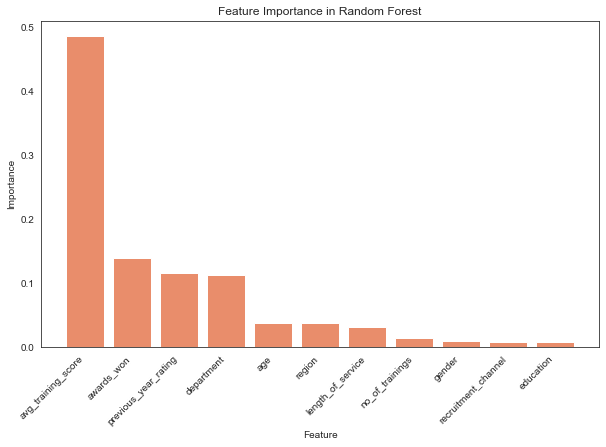

In [21]:
feature_importances = rf.feature_importances_

feature_names = X_train.columns

# Dictionary to associate features with their importance scores
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key = lambda x: x[1], reverse = True)

# Print the sorted feature importances
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Plotting
sns.set_palette("flare")

plt.figure(figsize = (10, 6))
plt.bar(range(len(sorted_features)), [importance for feature, importance in sorted_features], align = "center")
plt.xticks(range(len(sorted_features)), [feature for feature, importance in sorted_features], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.grid(False) 

plt.show()

From the chart above, it's noticeable that **avg_training_score** is the most important feature (48%) to predict whether employees will be recommended to be promoted, followed by **awards_won** (14%), **previous_year_rating** (12%), and **department** (11%). The other factors contribute below 4% to the predictive model.

## VI. Conclusions and suggestions for future research

The accuracy and precision rates of the prediction model are impressive, suggesting that the model produces reliable results. However, further research could explore alternative methods for handling missing data and consider employing neural network techniques to enhance the predictive model.